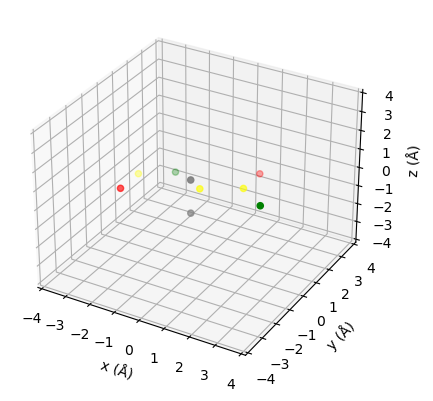

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp

#First, some help functions are created
#This is for finding the euclidean distance between two 3D vectors (in cartesian form)
def find_distance(r1, r2):
    return np.sqrt((r1[0]-r2[0])**2+(r1[1]-r2[1])**2+(r1[2]-r2[2])**2)

def find_angle(r1, r2, refpt1 = np.array([0,0,0]), refpt2 = np.array([0,0,0])):
    # Attempts to find the angle between 3D vectors, with reference points to shift the vectors
    return np.arccos(np.dot((r1-refpt1)/np.linalg.norm(r1-refpt1),
                                   (r2-refpt2)/np.linalg.norm(r2-refpt2)))

#This function rotates a vector around one of the cartesian axes through matrix multiplication
def rotate_vector(vector, theta, direction='x'):
    rotation_matrix = np.array([[0,0,0],[0,0,0],[0,0,0]])
    if direction=='x':
        rotation_matrix = np.array([[1,0,0],[0,np.cos(theta),-np.sin(theta)],[0,np.sin(theta),np.cos(theta)]])
    elif direction=='y':
        rotation_matrix = np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta),0,np.cos(theta)]])
    elif direction=='z':
        rotation_matrix = np.array([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])
    else:
        return vector
    rotated_vector = np.matmul(rotation_matrix, np.transpose(vector))
    return rotated_vector

#This function simply makes a list of the colours that each atom has and what position it has
def color_listing(dicti):
    i = 0
    for key in dicti.keys():
        for c in dicti[key]:
            i +=1
    color_list = np.empty(i, dtype=object)
    for key in dicti.keys():
        color = ''
        if key == "C":
            color = 'yellow'
        elif key == "H":
            color = 'gray'
        elif key == "N":
            color = 'green'
        elif key == "O":
            color = 'red'
        else:
            color = 'blue'
        for i in dicti[key]:
            color_list[i] = color
    return color_list

#Simply adds an R-group to the backbone-coordinates. Made such that expansion into different amino acids is easier
def add_alpha_group(backbonedict, rgroupdict):
    for key in rgroupdict.keys():
        backbonedict[key] = rgroupdict[key]
    return backbonedict

# def add_beta_group(backbonedict, rgroupdict):
#     # Does the same as above, but for a secondary beta group, which is placed relative to the beta carbon
#     for key in rgroupdict.keys():
#         backbonedict[key] = rgroupdict[key]+backbonedict["CbN"]
#     return backbonedict

#Lennard-Jones potential. e is a scaling factor, and s is the van der Waals radius for hydrogen.
def energy_eval(r, e=100, s=1.2):
    return 4*e*((s/r)**12 - (s/r)**6)

def main():
    ### Main function
    
    # We create two 360x360 matrices that will hold the energy evaluations and average distances
    energy_matrix = np.zeros([360,360])
    distance_matrix = np.zeros([360,360])  
    
    #Create some variables for bond lengths and angles for the backbone of the peptide
    CaN_l = 1.47
    CaN_a = np.radians(24)
    CaC_l = 1.53
    CaC_a = np.radians(31)
    CN_l = 1.32
    CN_a = np.radians(-35)
    
    # Then we define the constant backbone of an amino acid. This is a dictionary to keep track of where what is
    # Those with a key ending in p are rotated under phi rotation, those ending in s are rotated under psi rotation
    backbone_coordinates = {
                           "C_a": np.array([0, 0, 0]), 
                           "C1ap": np.array([CaC_l*np.cos(CaC_a), CaC_l*np.sin(CaC_a), 0]),
                           "O1C1p": np.array([CaC_l*np.cos(CaC_a), CaC_l*np.sin(CaC_a), 0])+np.array([0, 1.2, 0]),
                           "NpCp": np.array([CaC_l*np.cos(CaC_a), CaC_l*np.sin(CaC_a), 0])+np.array([CN_l*np.cos(CN_a), CN_l*np.sin(CN_a), 0]),
                           "NCas": np.array([-CaN_l*np.cos(CaN_a), CaN_l*np.sin(CaN_a), 0]),
                           "H1Ca": np.array([0, -0.89/np.sqrt(2), -0.89]),
                           "CpNs": np.array([-CaN_l*np.cos(CaN_a), CaN_l*np.sin(CaN_a), 0]-np.array([CN_l*np.cos(CN_a), -CN_l*np.sin(CN_a), 0]))
    }
    #Copy the backbone to another dictionary for safety
    initial_coordinates = backbone_coordinates.copy()
    #Add the oxygen connected to the left-most carbon (this was the easiest way)
    initial_coordinates["OCs"] = initial_coordinates["CpNs"]+np.array([0,-1.2,0])
    #Initialise the R-group (made to be expandable by adding more vectors)
    r_group_gly = { "H2Ca": np.array([0,-0.89/np.sqrt(2), 0.89])}
    #Adds the R-group to the backbone copy
    initial_coordinates = add_alpha_group(initial_coordinates, r_group_gly)
    
    #Start to loop through angles
    for i in range(0, 360):
#         First, create a copy of the coordinates of each atom
        coordinate_copy = initial_coordinates.copy()
    
#         Then, find the angle between the y-axis (0,1,0) and the first atom connected to the alpha carbon
#         along the phi bond.
        angi = find_angle(np.array([0,1,0]), coordinate_copy["C1ap"])
    
#         Rotate every vector around the z axis with this angle. Thus, the relative position of each vector
#         is the same, but now the carbon atom connected to the phi bond is along the y-axis.
        for key, value in coordinate_copy.items():
            coordinate_copy[key] = rotate_vector(value, angi, 'z')
            
#         Rotate each of the vectors that are on the phi "side" of the amino acid around the y-axis (which
#         is where the phi bond is aligned) by i-360 degrees. This way, the index [0,0] in our matrices correspond
#         to angles [-180,-180].
        for key in coordinate_copy.keys():
            if key[-1] == 'p':
                coordinate_copy[key] = rotate_vector(coordinate_copy[key], np.radians(i-360), 'y')
                
#         Then, find the angle between the nitrogen side (psi side of the amino acid) and the negative y-axis.
#         Rotate each vector by this amount to align the psi bond with the y axes (rotation around positive 
#         and negative y should be identical). This is to prepare for the psi rotations
        angj = find_angle(np.array([0,-1,0]), coordinate_copy["NCas"])
        for key, value in coordinate_copy.items():
            coordinate_copy[key] = rotate_vector(value, angj, 'z')
            
#         We then have to make a copy of this for use in the psi rotations. This is such that after each loop
#         we can reset the coordinates.
        jcopy = coordinate_copy.copy()
    
#         Now, we rotate around the psi bond, all 360 degrees.
        for j in range(0, 360):
#            Reset the coordinates
            coordinate_copy = jcopy.copy()
    
#            Rotate each vector by j-360 degrees (same reasoning as for i)
            for key in coordinate_copy.keys():
                if key[-1] == 's':
                    coordinate_copy[key] = rotate_vector(coordinate_copy[key], np.radians(j-360), 'y')
                    
#             Finally we find the distance between each of the atoms to the R-group, and add it together for the
#             correct spot in the energy matrix. Only atoms that have been rotated are considered.
            list_of_keys = coordinate_copy.keys()
            diff_matr = np.zeros(len(list_of_keys)-5)
            k = 0
            for c in list_of_keys:
                if c != "C_a" and c != "H2Ca" and c != "H1Ca" and c != "NCas" and c != "C1ap":
                    diff_matr[k] = find_distance(coordinate_copy[c], coordinate_copy["H2Ca"])
                    energy_matrix[i,j] += energy_eval(diff_matr[k])
                    k += 1
            distance_matrix[i,j] += np.sum(diff_matr)/k
                    
    #To properly visualise the atom, the position of each atom in the vector list is recorded and returned
    color_dict = {"H": [], "C": [], "N": [], "O": []}
    
    #This is then added to a dictionary
    c = 0
    for key in initial_coordinates.keys():
        first_char = key[0]
        if first_char in color_dict.keys():
            color_dict[first_char].append(c)
        else:
            color_dict[first_char] = []
            color_dict[first_char].append(c)
        c += 1
        
    #This dictionary is then sent to find the colour placements of everything
    color_list = color_listing(color_dict)
    
    #Returns the initial dictionary of positions, the list of colours, and the resulting energy and distance matrices.
    return initial_coordinates, color_list, energy_matrix, distance_matrix

output = main()

#Create an array out of the dictionary, to plot it
molecularmodel = []
for value in output[0].values():
    molecularmodel.append(value)
molecularmodel = np.array(molecularmodel)

#Plot the initial 3D vectors
ax = plt.axes(projection="3d")
ax.scatter3D(molecularmodel[:,0], molecularmodel[:,1], molecularmodel[:,2],color=output[1])
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ax.set_zlim(-4,4)
ax.set_zlabel("z (Å)")
ax.set_xlabel("x (Å)")
ax.set_ylabel("y (Å)")
plt.savefig("Moleculemodel.png")

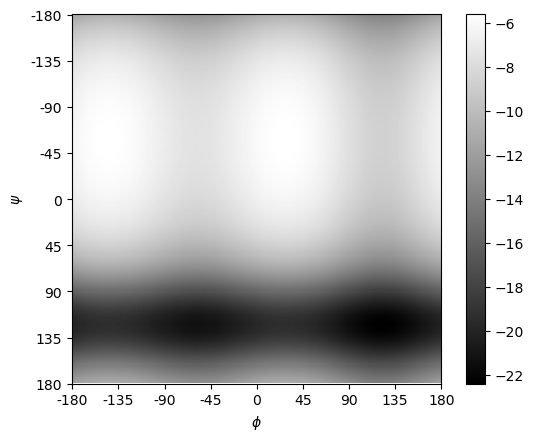

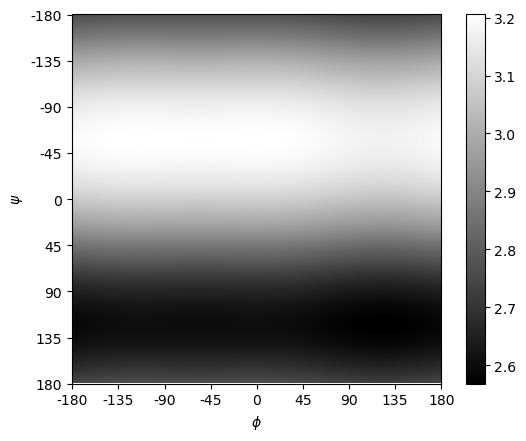

In [3]:
#Plot the energy and distance matrices, changing the axes to correctly start at -180.

fig, ax = plt.subplots()
im = ax.imshow(output[2].T, interpolation="none", cmap="gray")
ax.set_xticks(np.linspace(0,360,9))
ax.set_xticklabels([int(i) for i in np.linspace(-180,180,9)])
ax.set_yticks(np.linspace(0,360,9))
ax.set_yticklabels([int(i) for i in np.linspace(-180,180,9)])
fig.colorbar(im)
ax.set_ylabel(r"$\psi$")
ax.set_xlabel(r"$\phi$")
plt.savefig("Energy_plot.png")
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(output[3].T, interpolation="none", cmap="gray")
ax.set_xticks(np.linspace(0,360,9))
ax.set_xticklabels([int(i) for i in np.linspace(-180,180,9)])
ax.set_yticks(np.linspace(0,360,9))
ax.set_yticklabels([int(i) for i in np.linspace(-180,180,9)])
fig.colorbar(im)
ax.set_ylabel(r"$\psi$")
ax.set_xlabel(r"$\phi$")
plt.savefig("Distance_plot.png")
plt.show()